# THESIS - Model 

# Imports 

In [41]:
#imports

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import shlex, subprocess
import os , sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from Bio import SeqIO
import time

# 1. Preparation of the dataset 
- One hot encoding the sequences 

In [42]:
#one hot encoding
def fasta_to_onehotencode(seq) : 
    #values = list(seq)
    #values = np.array(values)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # label = int(line.strip()[1])
    
    
    sequence = seq 
    # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
    sequence_int = [base2int.get(base, 9999) for base in sequence]
    
    sequence_onehot = tf.one_hot(sequence_int, depth=4)
    
        
    return sequence_onehot

In [43]:
def fastatoarray(fasta_sequences) :
    seq_array = np.zeros((1,400,4)) 
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        new_sequence = fasta_to_onehotencode(sequence) #onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))
    seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
    return seq_array                    

In [44]:
_start_time = time.time()
#change a bit this function or cite 
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [45]:
#dataset upload, keeping the first four folders for training and testing and the last one for validation --> try with matrices not list

#/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/AARS_K562/fold-0/
from Bio import SeqIO
path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)


tic()

for folder in directory1:

    if folder == 'AARS_K562': #to be removed later 
        current_folder = folder
        directory2 = os.listdir(path + '/' + folder)
        
        seq_list_positive = np.zeros((1,400,4)) 
        seq_list_negative = np.zeros((1,400,4)) 
        seq_list_positive_test = np.zeros((1,400,4)) 
        seq_list_negative_test = np.zeros((1,400,4)) 
        
        for folder2 in directory2 :
            directory3 = os.listdir(path+ '/' + folder + '/' + folder2)
            
            if folder2 != "fold-4": #to be split into training and validation
            
                seq_list_positive_file = np.zeros((1,400,4)) 
                seq_list_negative_file = np.zeros((1,400,4)) 

                for file in directory3 :

                    if "fasta" in file :
                        fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                        seq_array = fastatoarray(fasta_sequences)
                        
                        if "positive" in file : 
                            seq_list_positive_file = np.vstack((seq_list_positive_file, seq_array))


                        if "negative-1" in file: # 2 neg: 1 pos with 'negative' --> 1 neg : 1 pos 'negative-1'
                            seq_list_negative_file = np.vstack((seq_list_negative_file, seq_array))
                            
                seq_list_negative_file = np.delete(seq_list_negative_file, 0, 0)
                seq_list_positive_file = np.delete(seq_list_positive_file, 0, 0)

                seq_list_positive = np.vstack((seq_list_positive, seq_list_positive_file))
                seq_list_negative = np.vstack((seq_list_negative, seq_list_negative_file))

  
                
            if folder2 == "fold-4": #for testing
                     
                    seq_list_positive_test_file = np.zeros((1,400,4)) 
                    seq_list_negative_test_file = np.zeros((1,400,4)) 

                    for file in directory3 :

                        if "fasta" in file :
                            fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                            seq_array = fastatoarray(fasta_sequences)

                            if "positive" in file : 
                                seq_list_positive_test_file = np.vstack((seq_list_positive_test_file, seq_array))
 

                            if "negative-1" in file: 
                                seq_list_negative_test_file = np.vstack((seq_list_negative_test_file, seq_array))
 
                    seq_list_negative_test_file = np.delete(seq_list_negative_test_file, 0, 0)
                    seq_list_positive_test_file = np.delete(seq_list_positive_test_file, 0, 0)

                    seq_list_positive_test = np.vstack((seq_list_positive_test, seq_list_positive_test_file))
                    seq_list_negative_test = np.vstack((seq_list_negative_test, seq_list_negative_test_file))
    
                    seq_list_negative_test = np.delete(seq_list_negative_test, 0, 0)
                    seq_list_positive_test = np.delete(seq_list_positive_test, 0, 0)  

        
                  
        seq_list_negative = np.delete(seq_list_negative, 0, 0)
        seq_list_positive = np.delete(seq_list_positive, 0, 0)

        


            
tac()


Time passed: 0hour:0min:21sec


- Preparation of the labels 

In [46]:
#preparation of the labels for the positive and negative dataset and validation set

labels_positive = np.ones((np.shape(seq_list_positive)[0], 1))

labels_negative = np.zeros((np.shape(seq_list_negative)[0], 1))
 
labels_positive_test = np.ones((np.shape(seq_list_positive_test)[0], 1))

labels_negative_test = np.zeros((np.shape(seq_list_negative_test)[0], 1))
print('Shape of labels: \n-positive : ',np.shape(labels_negative),'\n-negative : ', np.shape(labels_negative),'\n-positive validation : ',np.shape(labels_positive_test),'\n-negative validation : ',np.shape(labels_negative_test))

Shape of labels: 
-positive :  (2667, 1) 
-negative :  (2667, 1) 
-positive validation :  (720, 1) 
-negative validation :  (720, 1)


In [47]:
#merging the positive and negative datasets 
x = np.vstack((seq_list_positive, seq_list_negative))

x_test = np.vstack((seq_list_positive_test, seq_list_negative_test))

y = np.vstack((labels_positive, labels_negative))

y_test = np.vstack((labels_positive_test, labels_negative_test))


- Splitting of the dataset : test, train and validation sets 

In [48]:
#creation of the validation set 
import numpy as np
from sklearn.model_selection import train_test_split

#parameters 
test_size = 0.2

#test set

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle= True)

y_train = y_train.astype("float32")#actually useful?
y_val =y_val.astype("float32")
y_test = y_test.astype("float32")

x_train = x_train.astype("float32")
x_val = x_val.astype("float32")
x_test =x_test.astype("float32")



print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-validation set : ',np.shape(x_val),'\n-testing set : ', np.shape(x_test))

Shape of datasets: 
-training set :  (4267, 400, 4) 
-validation set :  (1067, 400, 4) 
-testing set :  (1440, 400, 4)


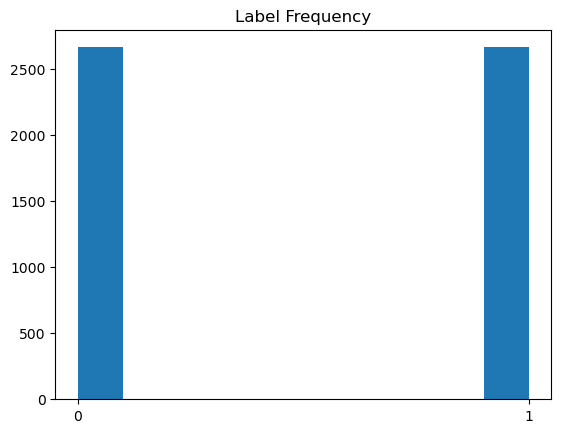

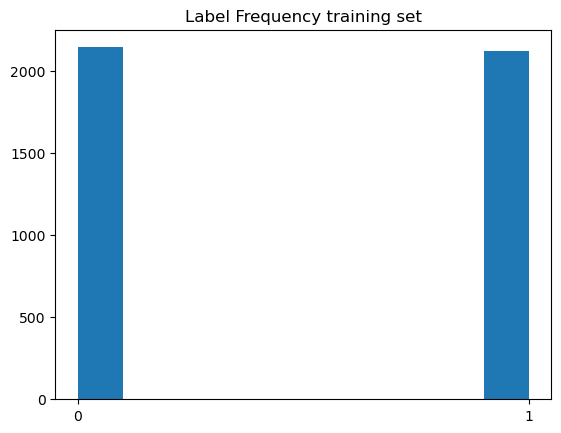

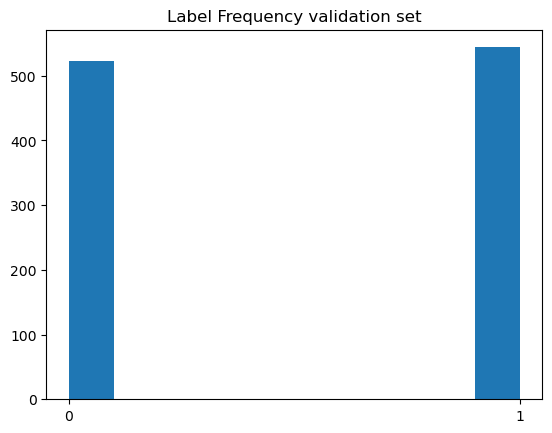

In [49]:
#checking class ditribution in the whole dataset and training set
import matplotlib.pyplot as plt

plt.hist(y)
plt.xticks(range(2))
plt.title('Label Frequency')
plt.show()

plt.hist(y_train)
plt.xticks(range(2))
plt.title('Label Frequency training set')
plt.show()

plt.hist(y_val)
plt.xticks(range(2))
plt.title('Label Frequency validation set')
plt.show()

# 2. Standard Model  

# 2.1 Create the baseline model 

In [50]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
]


In [51]:
#first is .compile() --> to create the baseline model : no dataset
def create_baseline():
    from tensorflow.keras.optimizers.legacy import Adam
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (400, 4)
    #batch_size = 32 # --> when batching the dataset, the model gives a graph error 
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))#, batch_size=batch_size))
    #model.add(keras.layers.Dropout(0.3)) -- seems better without this step
    
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer='random_normal', #to be changed once I have the actual input data -- from constant 1 ato random normal
             #glorot_uniform(seed=12)
              activation='relu'))#,input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer= 'random_normal', 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters

    model.add(keras.layers.Dense(1024, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(keras.layers.Dropout(0.6))
    
    model.add(keras.layers.Dense(128, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics= METRICS) # for binary classification
    
    #model.compile( optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),# Optimizer
                    # Loss function to minimize
                    #loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    #metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model


In [24]:
model = create_baseline()

print(model.layers)

print(model.summary()) 

[<keras.layers.convolutional.conv1d.Conv1D object at 0x7f706806dde0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7f70680dfb80>, <keras.layers.regularization.dropout.Dropout object at 0x7f70680971c0>, <keras.layers.convolutional.conv1d.Conv1D object at 0x7f7068095870>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7f7068094ac0>, <keras.layers.regularization.dropout.Dropout object at 0x7f7068095e40>, <keras.layers.reshaping.flatten.Flatten object at 0x7f7068123fd0>, <keras.layers.core.dense.Dense object at 0x7f70680ddd50>, <keras.layers.regularization.dropout.Dropout object at 0x7f70680de9b0>, <keras.layers.core.dense.Dense object at 0x7f70680df580>, <keras.layers.regularization.dropout.Dropout object at 0x7f70680dfbe0>, <keras.layers.core.dense.Dense object at 0x7f70680dcfd0>]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)       

In [15]:
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

#showing the mean and standard deviation of the estimated accuracy of the model on unseen data.

estimator = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold) #change to x_val and y_val
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [39]:
#trying to use tensorboard -- check VSCode
%load_ext tensorboard
%rm -rf ./logs/

%reload_ext tensorboard

%tensorboard --logdir logs/fit

display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px") 

AttributeError: 'PrecisionRecallDisplay' object has no attribute 'IFrame'

# 2.2 Fitting and Evaluating the Model

In [52]:
#second is to use .fit() --> to train the model : use x_train, y_train --> either .fit() or training loop from scratch (see below)
print("Fit model on training data")

model = create_baseline()

import datetime
#%tensorboard --logdir logs/fit
#parameters 
#batch_size=32
epochs= 50

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#introducing EarlyStopping to avoid overfitting 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


history = model.fit(
    x_train,
    y_train,
    #batch_size=batch_size, # --> the tf.dataset already batched the dataset 
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val,y_val),
    callbacks=my_callbacks
)

Fit model on training data
Epoch 1/50
134/134 [==============================] - 9s 22ms/step - loss: 0.6261 - tp: 1333.0000 - fp: 644.0000 - tn: 1500.0000 - fn: 790.0000 - accuracy: 0.6639 - precision: 0.6743 - recall: 0.6279 - auroc: 0.7159 - auprc: 0.7158 - val_loss: 0.5379 - val_tp: 384.0000 - val_fp: 119.0000 - val_tn: 404.0000 - val_fn: 160.0000 - val_accuracy: 0.7385 - val_precision: 0.7634 - val_recall: 0.7059 - val_auroc: 0.8065 - val_auprc: 0.8170
Epoch 2/50
134/134 [==============================] - 2s 15ms/step - loss: 0.5415 - tp: 1472.0000 - fp: 476.0000 - tn: 1668.0000 - fn: 651.0000 - accuracy: 0.7359 - precision: 0.7556 - recall: 0.6934 - auroc: 0.8054 - auprc: 0.8078 - val_loss: 0.5301 - val_tp: 380.0000 - val_fp: 98.0000 - val_tn: 425.0000 - val_fn: 164.0000 - val_accuracy: 0.7545 - val_precision: 0.7950 - val_recall: 0.6985 - val_auroc: 0.8337 - val_auprc: 0.8403
Epoch 3/50
134/134 [==============================] - 2s 15ms/step - loss: 0.5178 - tp: 1540.0000 - fp: 

In [53]:
#first attempt of a training loop from scratch --> added the evaluation loop here

model = create_baseline()


#parameters

input_shape = (400, 4)
epochs = 20 #for the test 
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)#parameter is recommended as true but creates an error
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()



import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #55 steps
        #print(step)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
        logits = model(x_train, training=True)  
            #print("Number of weights after calling the model:", len(model.weights))

            # Compute the loss value
        loss_value = loss_fn(y_train, logits)
    
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


    # Display metrics at the end of each epoch.
    train_acc= train_acc_metric.update_state(y_train, logits)
    
    train_acc = train_acc_metric.result()
    print(train_acc)
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
   # for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_val, training=False)

        # Update val metrics
    val_acc_metric.update_state(y_val, val_logits)
    
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    


Start of epoch 0
tf.Tensor(0.4973049, shape=(), dtype=float32)
Training acc over epoch: 0.4973
Validation acc: 0.5098
Time taken: 1.16s

Start of epoch 1
tf.Tensor(0.49753925, shape=(), dtype=float32)
Training acc over epoch: 0.4975
Validation acc: 0.5098
Time taken: 0.82s

Start of epoch 2
tf.Tensor(0.49917975, shape=(), dtype=float32)
Training acc over epoch: 0.4992
Validation acc: 0.5192
Time taken: 0.83s

Start of epoch 3
tf.Tensor(0.50456995, shape=(), dtype=float32)
Training acc over epoch: 0.5046
Validation acc: 0.5061
Time taken: 0.81s

Start of epoch 4
tf.Tensor(0.5158191, shape=(), dtype=float32)
Training acc over epoch: 0.5158
Validation acc: 0.4902
Time taken: 0.82s

Start of epoch 5
tf.Tensor(0.5221467, shape=(), dtype=float32)
Training acc over epoch: 0.5221
Validation acc: 0.4902
Time taken: 0.82s

Start of epoch 6
tf.Tensor(0.5071479, shape=(), dtype=float32)
Training acc over epoch: 0.5071
Validation acc: 0.4902
Time taken: 0.80s

Start of epoch 7
tf.Tensor(0.50621045

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auroc', 'auprc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auroc', 'val_auprc'])


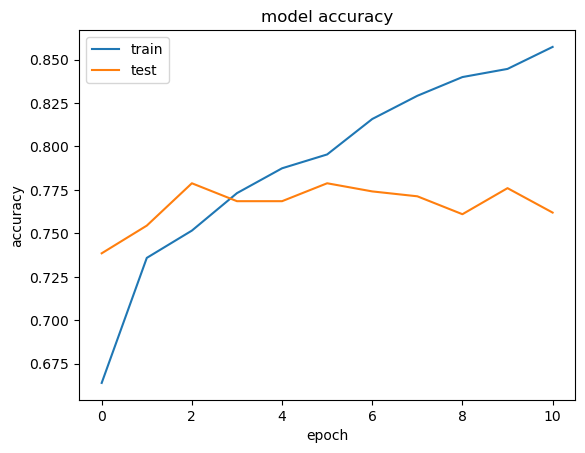

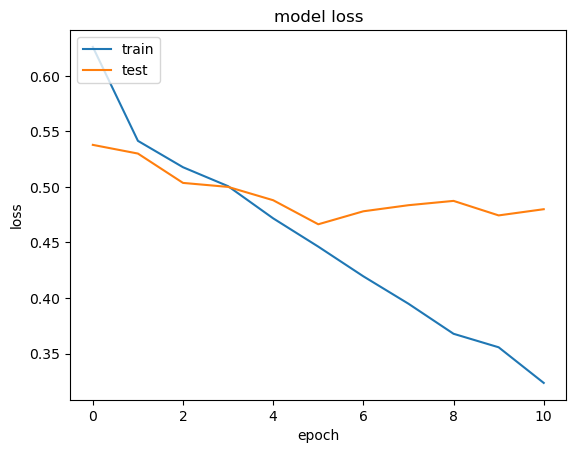

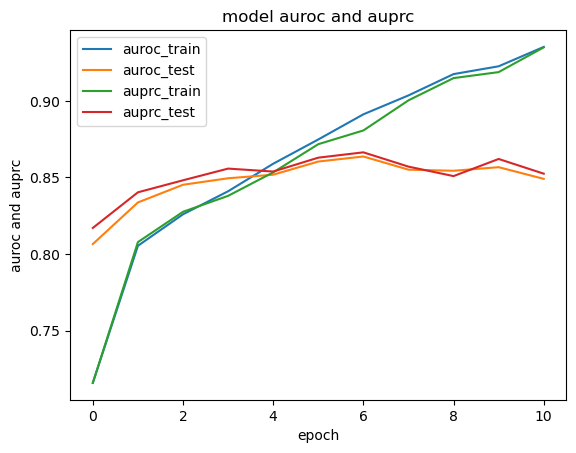

In [54]:
# list all data in history
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auroc 
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.plot(history.history['auprc'])
plt.plot(history.history['val_auprc'])
plt.title('model auroc and auprc')
plt.ylabel('auroc and auprc')
plt.xlabel('epoch')
plt.legend(['auroc_train', 'auroc_test','auprc_train', 'auprc_test'], loc='upper left')
plt.show()



# 2.3 Testing and saving 

In [55]:
model.save('best_models/standard_model_%s' % current_folder)

INFO:tensorflow:Assets written to: best_models/standard_model_AARS_K562/assets


INFO:tensorflow:Assets written to: best_models/standard_model_AARS_K562/assets


In [56]:
model = keras.models.load_model('best_models/standard_model_AARS_K562')


45/45 [==============================] - 1s 4ms/step


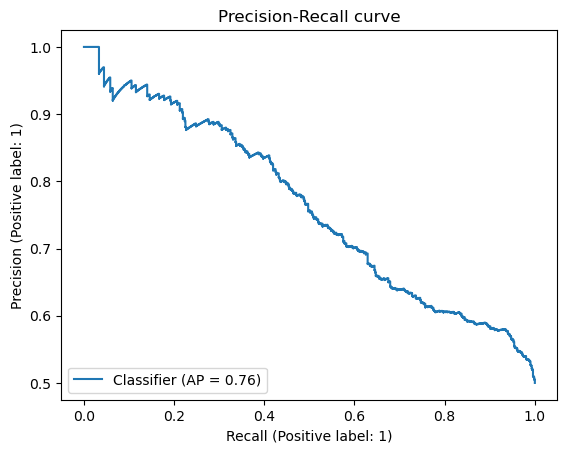

In [57]:
#testing and saving the predictions 
from sklearn.metrics import PrecisionRecallDisplay


y_pred = model.predict(x_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
_ = display.ax_.set_title("Precision-Recall curve")

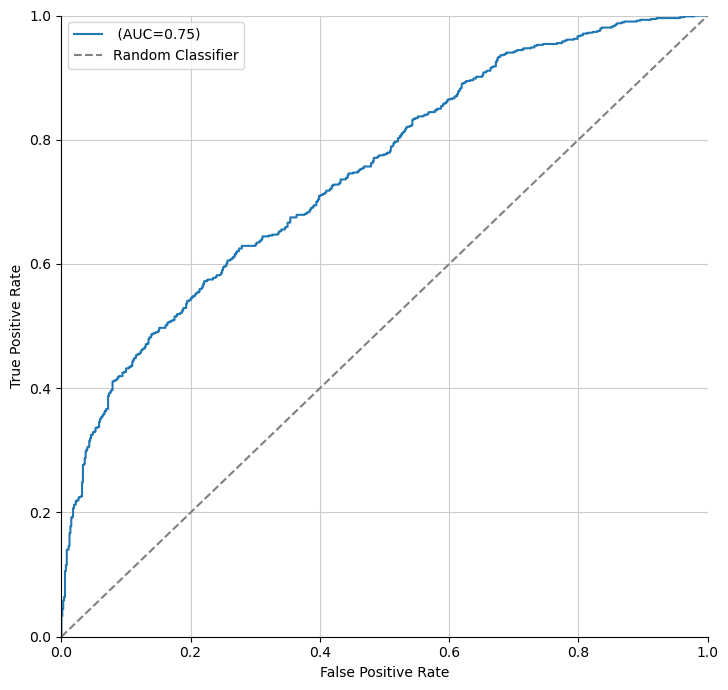

In [58]:
# Compute metrics for ROC Curve
import sklearn.metrics as metrics
import pylab as pl

fpr8, tpr8, thresholds8 = metrics.roc_curve(y_test, y_pred, drop_intermediate=False)

# Generate figure
fig = pl.figure(figsize=(14,7))
ax = fig.add_subplot(121)

pl.plot(fpr8, tpr8, label=" (AUC=%.2f)" % metrics.roc_auc_score(y_test, y_pred))
ax.plot([0,1], [0,1], color="grey",label="Random Classifier",linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.grid(color="#CCCCCC")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.legend()
pl.tight_layout()




# 3. Finding the best model via Random Search

In [21]:
#tuning of the model architecture 
def build_model(hp):
    
    
    from tensorflow.keras.optimizers.legacy import Adam
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (400, 4)
    #batch_size = 32 # --> when batching the dataset, the model gives a graph error 
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))#, batch_size=batch_size))
    #model.add(keras.layers.Dropout(0.3)) -- seems better without this step
    
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer='random_normal', #to be changed once I have the actual input data -- from constant 1 ato random normal
             #glorot_uniform(seed=12)
              activation='relu'))#,input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer= 'random_normal', 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters
    
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_{i}", min_value=32, max_value=1024, step=32),
            activation = 'relu'
            #activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="relu"))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    

    #model.add(keras.layers.Dense(1024, activation='relu'))#is it always relu? also sigmoid is an option
    '''model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=128, max_value=2400, step=32),
            activation="relu",
        )
    )
    model.add(keras.layers.Dropout(0.6))
    
    #model.add(keras.layers.Dense(128, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            activation="relu",
        )
    )'''
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    #many models train better when reducing the learning rate gradually -- not in this case!! see model2
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                                  0.001,
                                                                  decay_steps=50*1000,
                                                                  decay_rate=1,
                                                                  staircase=False)
    
    
    # Compile model
    #tf.keras.optimizers.Adam(lr_schedule) -- trying with the learning rate diminishing gradually
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=METRICS)
    
    #model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=METRICS) # for binary classification
    
    #model.compile( optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),# Optimizer
                    # Loss function to minimize
                    #loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    #metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model
    
    

In [22]:
import keras_tuner

model1 = build_model(keras_tuner.HyperParameters())

print(model1.summary())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="accuracy", #val_loss , val_accuracy .... 
    max_trials=5,# check
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="models",
)

print(tuner.search_space_summary())


tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 5 Complete [00h 00m 33s]
accuracy: 0.5176695783933004

Best accuracy So Far: 0.7368174393971761
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit


In [23]:
import keras_tuner

model2 = build_model(keras_tuner.HyperParameters())

print(model2.summary())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy", #val_loss , val_accuracy .... 
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="models",
)

print(tuner.search_space_summary())


tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 5 Complete [00h 00m 29s]
accuracy: 0.5715160965919495

Best accuracy So Far: 0.7352550625801086
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit


In [118]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=4)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 400, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 376, 30)           3030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 188, 30)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 188, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 30)           22530     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 30)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 82, 30)            0

In [25]:
# Get the top 2 models.
models2 = tuner.get_best_models(num_models=4)
best_model2 = models2[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model2.build(input_shape=(None, 400, 4))
best_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 376, 30)           3030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 188, 30)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 188, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 30)           22530     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 30)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 82, 30)            0

In [119]:
tuner.results_summary()

'''tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""") -- nice 

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 896
dropout: True
lr: 0.0004893954054196937
units_1: 32
units_2: 32
Score: 0.7426763574282328
Trial summary
Hyperparameters:
num_layers: 3
units_0: 192
dropout: True
lr: 0.0016380235981496075
units_1: 800
units_2: 192
Score: 0.7310366233189901
Trial summary
Hyperparameters:
num_layers: 1
units_0: 960
dropout: False
lr: 0.00035910093218825
units_1: 32
units_2: 64
Score: 0.6654948790868124
Trial summary
Hyperparameters:
num_layers: 1
units_0: 384
dropout: False
lr: 0.00024335509762462415
units_1: 224
units_2: 160
Score: 0.6505741675694784
Trial summary
Hyperparameters:
num_layers: 2
units_0: 448
dropout: False
lr: 0.000501777635589437
units_1: 96
units_2: 928
Score: 0.6414342522621155


In [120]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), #hyperparameter to tune 
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model1 = build_model(best_hps[0])
# Fit with the entire dataset.
#x_all = np.concatenate((x_train, x_val))
#y_all = np.concatenate((y_train, y_val))
history = model1.fit(x_train, y_train, epochs=200, validation_data= (x_val,y_val), callbacks = my_callbacks)


#find the optimal amount of epochs and then refit the model -- IT-S NOT BEEN RUN  -- not necessary 
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,)) 


Epoch 1/10
167/167 [==============================] - 3s 13ms/step - loss: 0.6472 - accuracy: 0.6067
Epoch 2/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5869 - accuracy: 0.6775
Epoch 3/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5748 - accuracy: 0.6910
Epoch 4/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5512 - accuracy: 0.7372
Epoch 5/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5430 - accuracy: 0.7492
Epoch 6/10
167/167 [==============================] - 2s 13ms/step - loss: 0.5328 - accuracy: 0.7572
Epoch 7/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5100 - accuracy: 0.7778
Epoch 8/10
167/167 [==============================] - 2s 13ms/step - loss: 0.4907 - accuracy: 0.7898
Epoch 9/10
167/167 [==============================] - 2s 12ms/step - loss: 0.4778 - accuracy: 0.7992
Epoch 10/10
167/167 [==============================] - 2s 12ms/step - loss: 0.4595 - accura

In [ ]:
#retrain the model with the optimal number of epochs
model1 = build_model(best_hps[0])
history = model1.fit(x_train, y_train, epochs=50, validation_data= (x_val,y_val), callbacks = my_callbacks)

#evaluation
eval_result = model1.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)


In [29]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model2 = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
history = model2.fit(x=x_all, y=y_all, epochs=20, callbacks = my_callbacks)

Epoch 1/20
167/167 [==============================] - 3s 11ms/step - loss: 0.6620 - tp: 4660.0000 - fp: 3444.0000 - tn: 5085.0000 - fn: 3880.0000 - accuracy: 0.5709 - precision: 0.5750 - recall: 0.5457 - auroc: 0.6175 - auprc: 0.6285
Epoch 2/20
167/167 [==============================] - 2s 10ms/step - loss: 0.6002 - tp: 2000.0000 - fp: 1006.0000 - tn: 1661.0000 - fn: 667.0000 - accuracy: 0.6864 - precision: 0.6653 - recall: 0.7499 - auroc: 0.7462 - auprc: 0.7408
Epoch 3/20
167/167 [==============================] - 2s 10ms/step - loss: 0.5708 - tp: 2109.0000 - fp: 1004.0000 - tn: 1663.0000 - fn: 558.0000 - accuracy: 0.7072 - precision: 0.6775 - recall: 0.7908 - auroc: 0.7845 - auprc: 0.7835
Epoch 4/20
167/167 [==============================] - 2s 11ms/step - loss: 0.5512 - tp: 2101.0000 - fp: 915.0000 - tn: 1752.0000 - fn: 566.0000 - accuracy: 0.7223 - precision: 0.6966 - recall: 0.7878 - auroc: 0.8024 - auprc: 0.7960
Epoch 5/20
167/167 [==============================] - 2s 11ms/step -

In [21]:
#to be deleted
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = reconstructed_model1.fit(x_train, y_train, epochs=10, validation_data=(x_val,y_val), callbacks = my_callbacks )

Epoch 1/10
134/134 [==============================] - 7s 28ms/step - loss: 0.4367 - accuracy: 0.8245 - val_loss: 0.3811 - val_accuracy: 0.8913
Epoch 2/10
134/134 [==============================] - 2s 17ms/step - loss: 0.4101 - accuracy: 0.8406 - val_loss: 0.3561 - val_accuracy: 0.8744
Epoch 3/10
134/134 [==============================] - 2s 17ms/step - loss: 0.3889 - accuracy: 0.8439 - val_loss: 0.3353 - val_accuracy: 0.8932
Epoch 4/10
134/134 [==============================] - 2s 16ms/step - loss: 0.3661 - accuracy: 0.8580 - val_loss: 0.3327 - val_accuracy: 0.8857
Epoch 5/10
134/134 [==============================] - 2s 16ms/step - loss: 0.3431 - accuracy: 0.8770 - val_loss: 0.2917 - val_accuracy: 0.8960
Epoch 6/10
134/134 [==============================] - 2s 17ms/step - loss: 0.3240 - accuracy: 0.8856 - val_loss: 0.3629 - val_accuracy: 0.8322
Epoch 7/10
134/134 [==============================] - 2s 17ms/step - loss: 0.2977 - accuracy: 0.8964 - val_loss: 0.3190 - val_accuracy: 0.8828

# 3.1 Evaluating and saving the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


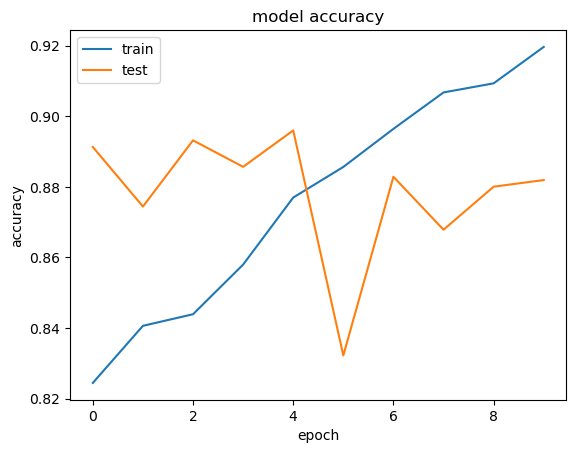

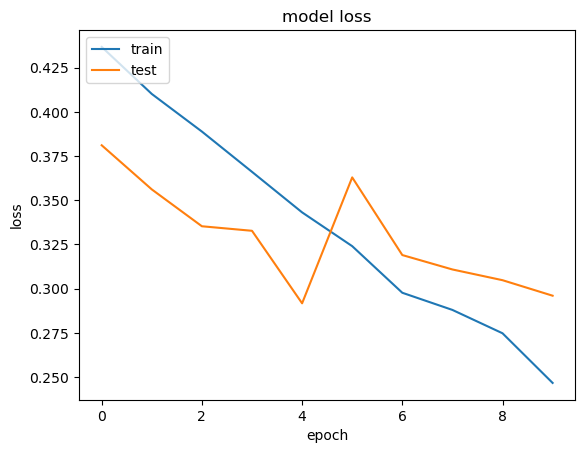

In [23]:
# list all data in history
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auroc', 'auprc'])


KeyError: 'val_accuracy'

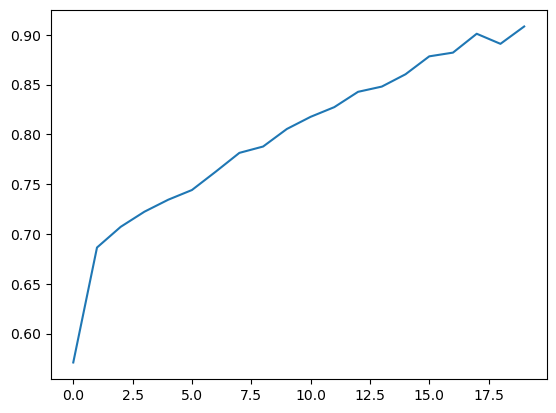

In [30]:
# list all data in history
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
#saving the best model for testing and aggregated evaluation later

model1.save('best_models/best_model_%s' % current_folder)

#del model1

INFO:tensorflow:Assets written to: best_models/best_model_AARS_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model_AARS_K562/assets


In [33]:
#saving the best model for testing and aggregated evaluation later

model2.save('best_models/best_model2_%s' % current_folder)

#del model1

INFO:tensorflow:Assets written to: best_models/best_model2_AARS_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model2_AARS_K562/assets


# 3.2 Reloading and testing the model 

In [59]:
#reloading the model to compute the predictions

reconstructed_model1 = keras.models.load_model('best_models/best_model_AARS_K562')


In [72]:
#reloading the model to compute the predictions

reconstructed_model2 = keras.models.load_model('best_models/best_model2_AARS_K562')


45/45 [==============================] - 0s 4ms/step


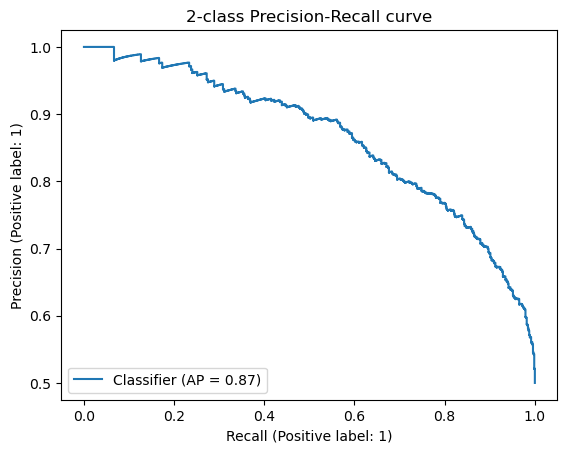

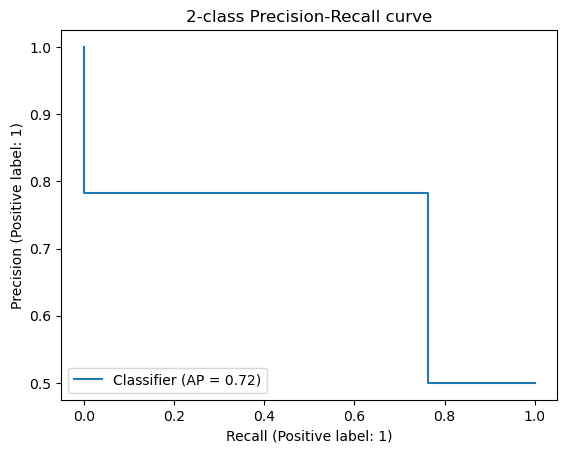

In [73]:
#testing and saving the predictions --> I can use the whole dataset now and it shouldn't overfit right?
from sklearn.metrics import PrecisionRecallDisplay


y_pred = reconstructed_model1.predict(x_test)

threshold = 0.5

y_pred2 = np.where(y_pred > threshold, 1,0)

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred2)
_ = display.ax_.set_title("2-class Precision-Recall curve")


45/45 [==============================] - 0s 4ms/step


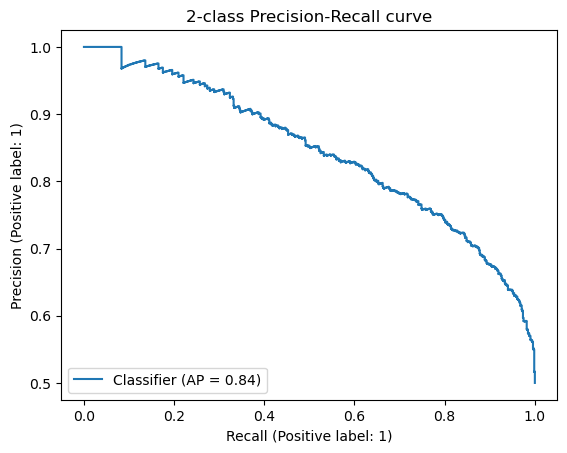

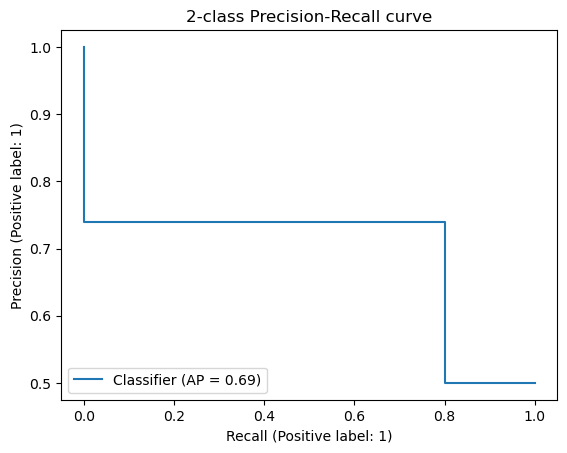

In [74]:
#testing and saving the predictions --> I can use the whole dataset now and it shouldn't overfit right?
from sklearn.metrics import PrecisionRecallDisplay


y_pred = reconstructed_model2.predict(x_test)

threshold = 0.5

y_pred2 = np.where(y_pred > threshold, 1,0)

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
_ = display.ax_.set_title("2-class Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred2)
_ = display.ax_.set_title("2-class Precision-Recall curve")


[[516 204]
 [143 577]]


<AxesSubplot: >

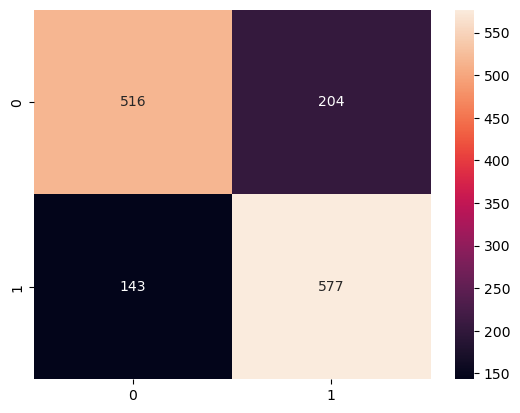

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Get the confusion matrix model2

cf_matrix = confusion_matrix(y_test, y_pred2)

print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, fmt = "d")

[[567 153]
 [171 549]]


<AxesSubplot: >

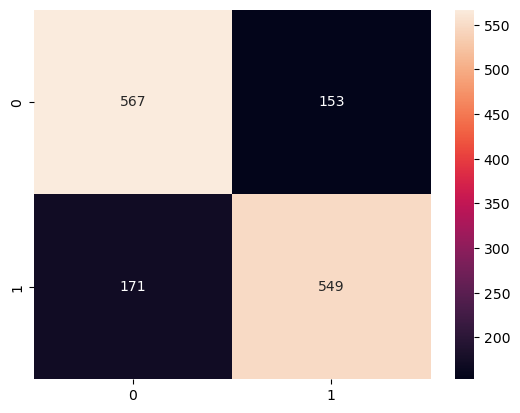

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Get the confusion matrix model1

cf_matrix = confusion_matrix(y_test, y_pred2)

print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, fmt = "d")

<AxesSubplot: >

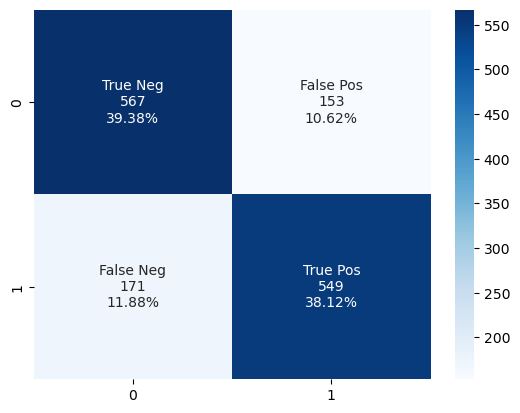

In [68]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

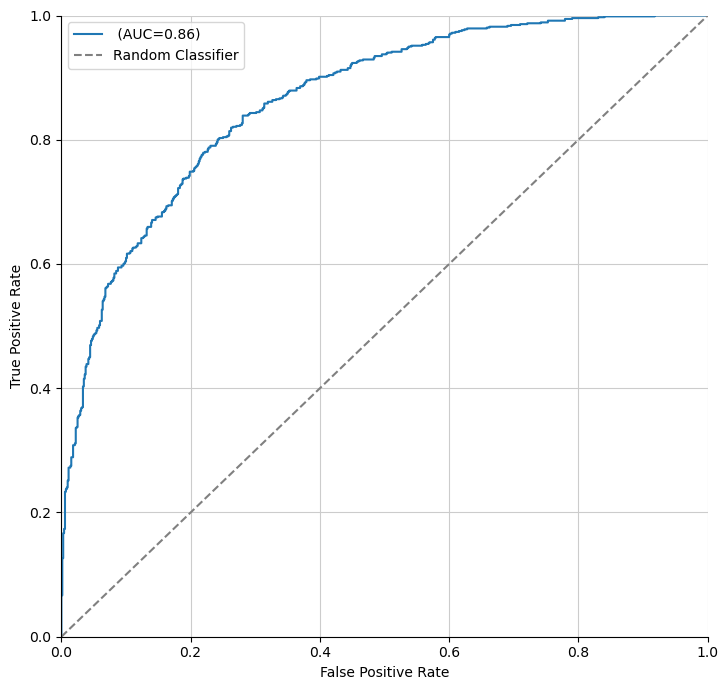

In [69]:
# Compute metrics for ROC Curve
import sklearn.metrics as metrics
import pylab as pl

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, drop_intermediate=False)

# Generate figure
fig = pl.figure(figsize=(14,7))
ax = fig.add_subplot(121)

pl.plot(fpr, tpr, label=" (AUC=%.2f)" % metrics.roc_auc_score(y_test, y_pred))
ax.plot([0,1], [0,1], color="grey",label="Random Classifier",linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.grid(color="#CCCCCC")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.legend()
pl.tight_layout()

#fig.add_subplot(122)

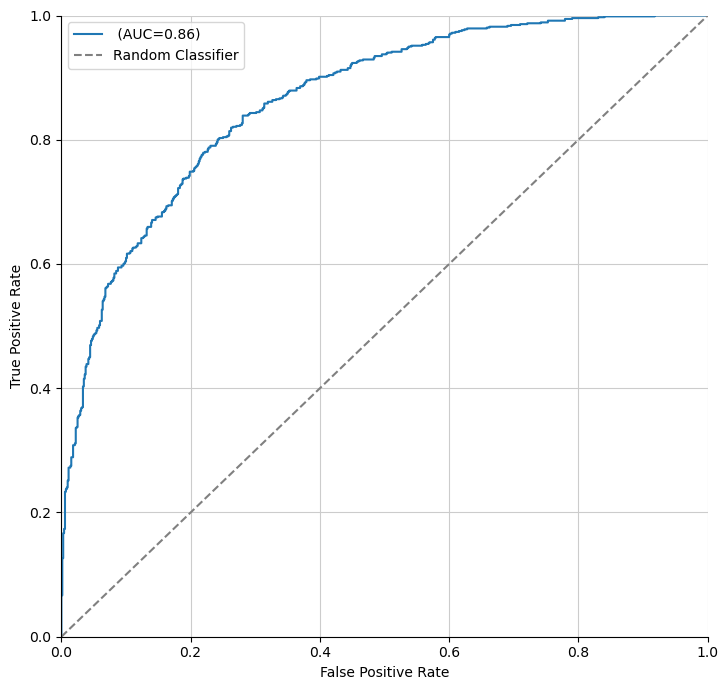

In [70]:
# Compute metrics for ROC Curve -- save ypred and y test in a df
import sklearn.metrics as metrics
import pylab as pl

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, drop_intermediate=False)

# Generate figure
fig = pl.figure(figsize=(14,7))
ax = fig.add_subplot(121)

pl.plot(fpr, tpr, label=" (AUC=%.2f)" % metrics.roc_auc_score(y_test, y_pred))
ax.plot([0,1], [0,1], color="grey",label="Random Classifier",linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.grid(color="#CCCCCC")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.legend()
pl.tight_layout()

#fig.add_subplot(122)

# 3.3 Saving the predictions

In [71]:
#saving the predictions (0,1) in a csv file -- in probabilities 

import pandas as pd 
pd.DataFrame(y_pred2).to_csv("predictions/%s.csv" % current_folder)